In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.3.0
TFP version: 0.11.1


# Variational autoencoders

## Coding tutorials

#### [1. Encoders and decoders](#tutorial1)
#### [2. Minimising Kullback-Leibler divergence](#tutorial2)
#### [3. Maximising the ELBO](#tutorial3)
#### [4. KL divergence layers](#tutorial4)

***
<a class="anchor" id="tutorial1"></a>
## Encoders and decoders

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, ReLU, LeakyReLU, Dense, Flatten, Reshape
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [3]:
# Load Fashion MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])
print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)

shape of x_train: (60000, 28, 28, 1)
shape of x_test: (10000, 28, 28, 1)


shape of example_images: (1000, 28, 28, 1)


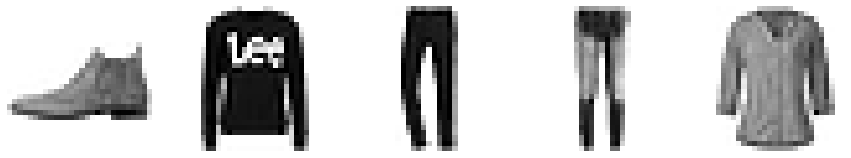

In [4]:
# Display a few examples

n_examples = 1000
example_images = x_test[0:n_examples]
print('shape of example_images:', example_images.shape)
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [5]:
# Define the encoder

dim_latent = 2
ae_encoder = Sequential([
    Conv2D(8, (3, 3), strides=2, padding='same', input_shape=x_train.shape[1:]),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(16, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(64),
    LeakyReLU(),
    Dense(dim_latent)
])

In [6]:
ae_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0

In [7]:
# Encode examples before training

pretrain_example_encodings = ae_encoder(example_images)
print('shape of pretrain_example_encodings:', pretrain_example_encodings.shape)

shape of pretrain_example_encodings: (1000, 2)


c:\programdata\anaconda3\envs\dev\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


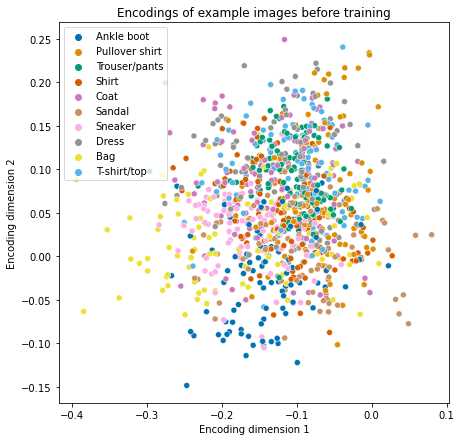

In [8]:
# Plot encoded examples before training 

f, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=ax,
                palette=sns.color_palette("colorblind", 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

In [9]:
# Define the decoder

ae_decoder = Sequential([
    Dense(64, activation='relu', input_shape=(dim_latent,)),
    Dense(256, activation='relu'),
    Dense(7 * 7 * 16, activation='relu'),
    Reshape((7, 7, 16)),
    Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='sigmoid')  # outputs are between [0, 1] like inputs
])

In [10]:
ae_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         1160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 8)        

In [11]:
# Compile and fit the model

autoencoder = Model(ae_encoder.input, ae_decoder(ae_encoder.output))

# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss

autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Fit model - highlight that labels and input are the same

n_epochs = 20
batch_size = 256
autoencoder.fit(x_train, x_train, epochs=n_epochs, batch_size=batch_size)

Epoch 1/20
235/235 [==============================] - 2s 10ms/step - loss: 0.4713
Epoch 2/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3493
Epoch 3/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3336
Epoch 4/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3289: 0s - loss: 0
Epoch 5/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3263
Epoch 6/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3246
Epoch 7/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3238
Epoch 8/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3225
Epoch 9/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3219
Epoch 10/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3213: 0s - los
Epoch 11/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3208
Epoch 12/20
235/235 [==============================] - 2s 10ms/step - lo

In [12]:
# Compute example encodings after training

posttrain_example_encodings = ae_encoder(example_images)

c:\programdata\anaconda3\envs\dev\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\dev\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


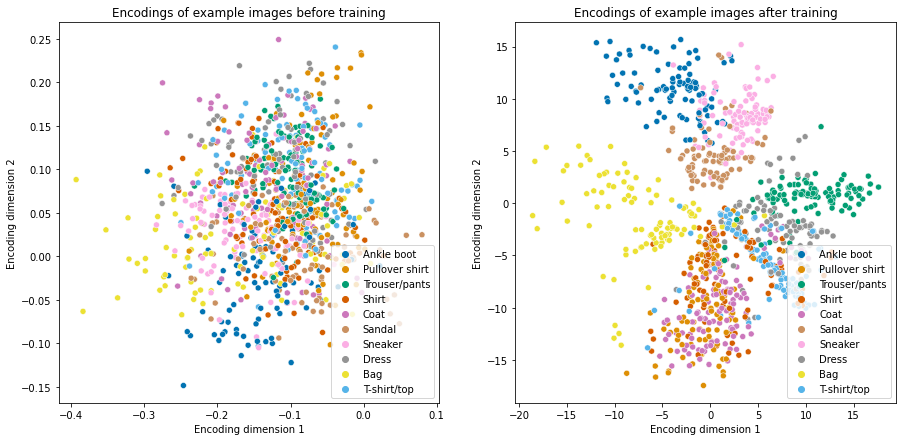

In [13]:
# Compare the example encodings before and after training

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 10));
sns.scatterplot(posttrain_example_encodings[:, 0],
                posttrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')

In [14]:
# Compute the autoencoder's reconstructions

reconstructed_example_images = autoencoder(example_images)

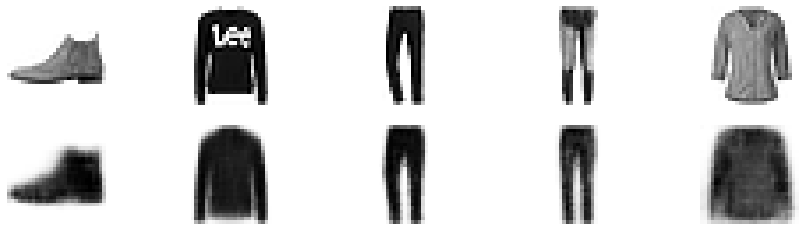

In [15]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

***
<a class="anchor" id="tutorial2"></a>
## Minimising Kullback-Leibler divergence

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [17]:
# Define a target distribution, p

loc = [0, 0]
scale_tril = tfb.FillScaleTriL()(tf.random.uniform([3]))

print('scale_tril:', scale_tril)

p = tfd.MultivariateNormalTriL(loc, scale_tril)
p

scale_tril: tf.Tensor(
[[1.1683826  0.        ]
 [0.17858303 1.0504051 ]], shape=(2, 2), dtype=float32)


<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

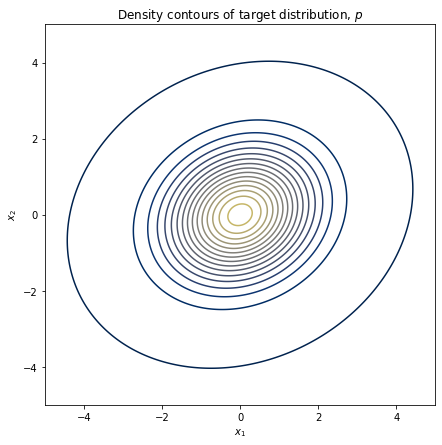

In [18]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$');

In [19]:
# Initialize an approximating distribution, q, that has diagonal covariance

q = tfd.MultivariateNormalDiag(
    loc=tf.Variable(tf.random.normal([2]), name='q_loc'),
    scale_diag=tf.Variable(
        tf.random.uniform([2]),
        name='q_scale_diag',
        constraint=lambda v: tf.nn.relu(v)  # scales must be nonnegative
    )
)

In [20]:
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [21]:
q.trainable_variables

(<tf.Variable 'q_loc:0' shape=(2,) dtype=float32, numpy=array([-0.20712008,  0.83571327], dtype=float32)>,
 <tf.Variable 'q_scale_diag:0' shape=(2,) dtype=float32, numpy=array([0.801968  , 0.04648995], dtype=float32)>)

In [22]:
tfd.kl_divergence(q, p)

<tf.Tensor: shape=(), dtype=float32, numpy=3.094>

In [23]:
# Define a function for the Kullback-Leibler divergence

@tf.function
def loss_and_grads(dist_a, dist_b, reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfd.kl_divergence(dist_a, dist_b)
        else:
            loss = tfd.kl_divergence(dist_b, dist_a)   
        grads = tape.gradient(loss, dist_a.trainable_variables)
    return loss, grads

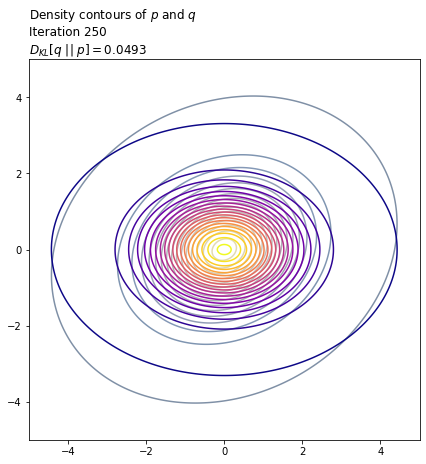

In [24]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

In [25]:
# Re-fit the distribution, this time fitting q_rev by minimising KL[p || q_rev]

q_rev = tfd.MultivariateNormalDiag(
    loc=tf.Variable(tf.random.normal([2]), name='q_rev_loc'),
    scale_diag=tf.Variable(
        tf.random.uniform([2]),
        name='q_scale_diag',
        constraint=lambda v: tf.nn.relu(v)  # scales must be nonnegative
    )
)

In [26]:
# Edit loss_and_grads function

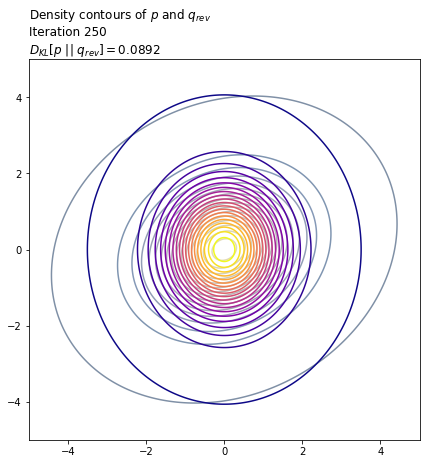

In [27]:
# Re-initialize optimizer, run training loop

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads(q_rev, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

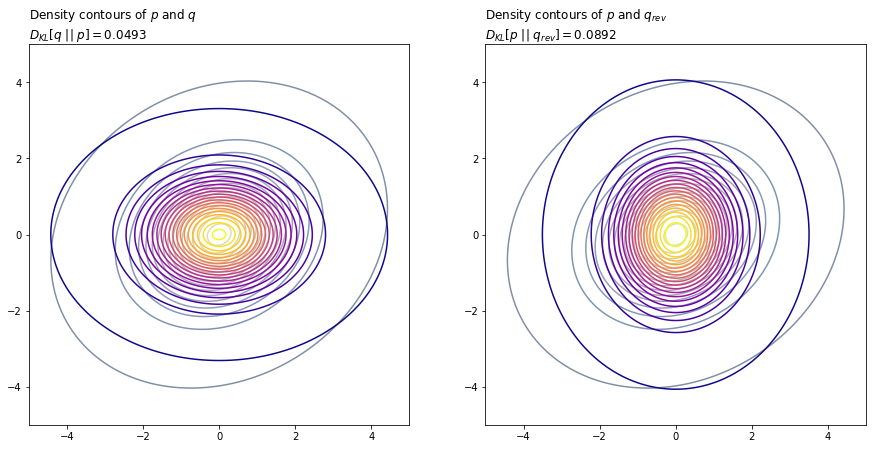

In [28]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

---
<a class="anchor" id="tutorial3"></a>
## Maximising the ELBO 

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

\begin{align}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[−\log q(Z | x) + \log p(x, Z)\big]\\
          &= - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] + \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big] 
\end{align}

In [29]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)
event_shape = x_train.shape[1:]

example_x = x_test[:16]

batch_size = 256
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
x_train

shape of x_train: (60000, 28, 28, 1)
shape of x_test: (10000, 28, 28, 1)


<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [31]:
# Define the encoding distribution, q(z|x)

dim_latent = 2
vae_encoder = Sequential([
    Conv2D(8, (3, 3), strides=2, padding='same', input_shape=event_shape),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(16, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(64),
    LeakyReLU(),
    Dense(tfpl.IndependentNormal.params_size(dim_latent)),
    tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :dim_latent],
            scale_diag=tfb.Exp()(t[..., dim_latent:])
        )
    )
    # equivalently,
    # tfpl.IndependentNormal(dim_latent)
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [32]:
vae_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)              

In [33]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.

vae_encoder(example_x)

<tfp.distributions.MultivariateNormalDiag 'sequential_2_distribution_lambda_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [34]:
# Define the decoding distribution, p(x|z)

vae_decoder = Sequential([
    Dense(64, activation='relu', input_shape=(dim_latent,)),
    Dense(256, activation='relu'),
    Dense(7 * 7 * 16, activation='relu'),
    Reshape((7, 7, 16)),
    Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2DTranspose(1, (3, 3), strides=2, padding='same'),  # no activation function
    Flatten(),
    tfpl.IndependentBernoulli(event_shape)
])

In [35]:
vae_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 8)         1160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 8)        

In [36]:
# Pass a batch of examples to the decoder

vae_decoder(vae_encoder(example_x))

<tfp.distributions.Independent 'sequential_3_independent_bernoulli_IndependentBernoulli_Independentsequential_3_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28, 1] dtype=float32>

In [37]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(dim_latent))

The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation}
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
\end{equation}

In [38]:
# Specify the loss function, an estimate of the -ELBO

def negative_elbo(x, dist_enc, dist_dec, prior):
    return tf.reduce_sum(tfd.kl_divergence(dist_enc, prior) - dist_dec.log_prob(x))

In [39]:
# Define a function that returns the loss and its gradients

@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        dist_enc = vae_encoder(x)
        z_sample = dist_enc.sample()
        dist_dec = vae_decoder(z_sample)
        loss = negative_elbo(x, dist_enc, dist_dec, prior)
        grads = tape.gradient(loss, vae_encoder.trainable_variables + vae_decoder.trainable_variables)
    return loss, grads

In [40]:
# Compile and train the model

num_epochs = 20
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, vae_encoder.trainable_variables
                                       + vae_decoder.trainable_variables))
        
    print('-ELBO after epoch {:d}: {:.2f}'.format(i+1, loss.numpy()))

-ELBO after epoch 1: 31760.49
-ELBO after epoch 2: 30010.71
-ELBO after epoch 3: 28673.33
-ELBO after epoch 4: 28045.60
-ELBO after epoch 5: 27885.66
-ELBO after epoch 6: 27610.28
-ELBO after epoch 7: 27655.23
-ELBO after epoch 8: 27466.95
-ELBO after epoch 9: 27265.74
-ELBO after epoch 10: 27223.56
-ELBO after epoch 11: 27118.14
-ELBO after epoch 12: 27040.34
-ELBO after epoch 13: 27040.02
-ELBO after epoch 14: 26985.30
-ELBO after epoch 15: 26983.12
-ELBO after epoch 16: 26902.75
-ELBO after epoch 17: 27002.72
-ELBO after epoch 18: 26836.35
-ELBO after epoch 19: 26858.76
-ELBO after epoch 20: 26785.35


In [41]:
# Connect encoder and decoder, compute a reconstruction

def vae(x, mean=True):
    p_z_given_x = vae_encoder(x)
    z_sample = p_z_given_x.sample()
    p_x_given_z = vae_decoder(z_sample)
    if mean:
        return p_x_given_z.mean()
    else:
        return p_x_given_z.sample()

example_reconstruction = vae(example_x)
print('shape of example_reconstruction:', example_reconstruction.shape)

shape of example_reconstruction: (16, 28, 28, 1)


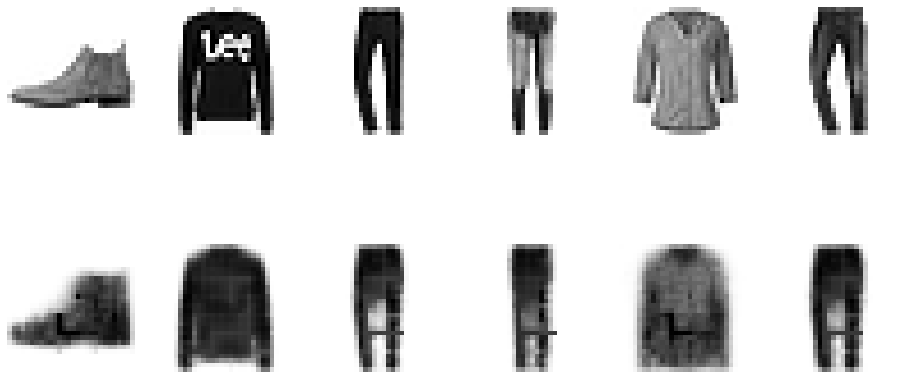

In [42]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 8))

for j in range(6):
    axs[0, j].imshow(example_x[j], cmap='binary')
    axs[1, j].imshow(example_reconstruction[j], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [43]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

n_z_samples = 6
z = prior.sample(n_z_samples)
n_x_samples = 3
vae_decoder(z)

<tfp.distributions.Independent 'sequential_3_independent_bernoulli_IndependentBernoulli_Independentsequential_3_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[6] event_shape=[28, 28, 1] dtype=float32>

In [44]:
generated_x = vae_decoder(z).sample(n_x_samples)
generated_x_mean = vae_decoder(z).mean()
print('shape of generated_x:', generated_x.shape)
print('shape of generated_x_mean:', generated_x_mean.shape)

shape of generated_x: (3, 6, 28, 28, 1)
shape of generated_x_mean: (6, 28, 28, 1)


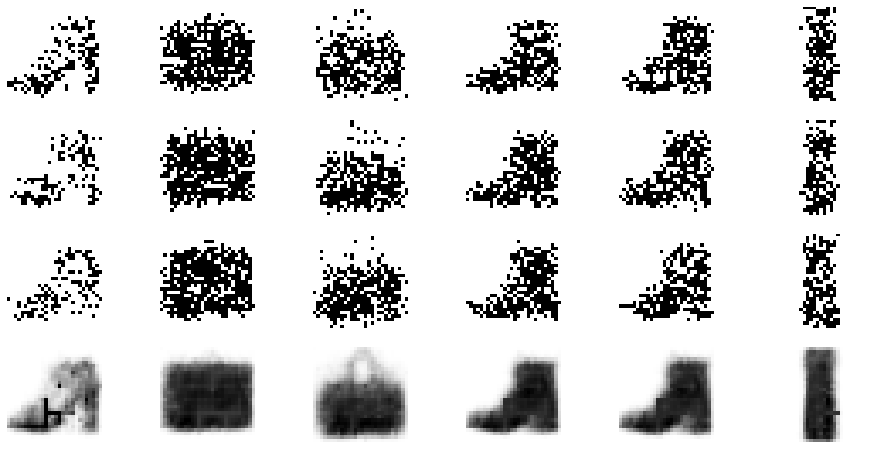

In [45]:
# Display generated_x

f, axs = plt.subplots(n_x_samples+1, n_z_samples, figsize=(16, 8))
for i in range(n_x_samples):
    for j in range(n_z_samples):
        axs[i, j].imshow(generated_x[i, j], cmap='binary')
        axs[i, j].axis('off')
for j in range(n_z_samples):
    axs[n_x_samples, j].imshow(generated_x_mean[j], cmap='binary')
    axs[n_x_samples, j].axis('off')

In [46]:
# -ELBO estimate using an estimate of the KL divergence

def loss(x, encoding_dist, sampled_decoding_dist, prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z) - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + recon_loss)

***
<a class="anchor" id="tutorial4"></a>
# KL divergence layers

In [47]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [48]:
# Import Fashion MNIST

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256. + 0.5/256

x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)
event_shape = x_train.shape[1:]

example_x = x_test[:16]

batch_size = 256
x_train = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)
x_test = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

shape of x_train: (60000, 28, 28, 1)
shape of x_test: (10000, 28, 28, 1)


In [49]:
# Define latent_size and the prior, p(z)

dim_latent = 2
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(dim_latent))

In [50]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer

vae_encoder = Sequential([
    Conv2D(8, (3, 3), strides=2, padding='same', input_shape=event_shape),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(16, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(64),
    LeakyReLU(),
    Dense(tfpl.MultivariateNormalTriL.params_size(dim_latent)),
    tfpl.MultivariateNormalTriL(dim_latent),
    tfpl.KLDivergenceAddLoss(
        prior,
        use_exact_kl=False,
        test_points_fn=lambda q: q.sample(10),
        test_points_reduce_axis=0
    )  # add Monte-Carlo estimated KL(q(z|x) | p(z)) to the entire loss
    # equivalently,
    # tfpl.MultivariateNormalTriL(
    #     dim_latent,
    #     activity_regularizer=tfpl.KLDivergenceRegularizer(
    #         prior,
    #         use_exact_kl=False,
    #         test_points_fn=lambda q: q.sample(10),
    #         test_points_reduce_axis=0
    #     )
    # )
])

In [51]:
vae_encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)              

In [52]:
# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs

vae_encoder.losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [53]:
# Pass a batch of images through the encoder

vae_encoder(example_x)

<tfp.distributions.MultivariateNormalTriL 'sequential_4_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[2] dtype=float32>

In [54]:
# See how encoder.losses has changed

vae_encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=3.8063552>]

In [55]:
# Specify the decoder, p(x|z)

vae_decoder = Sequential([
    Dense(64, activation='relu', input_shape=(dim_latent,)),
    Dense(256, activation='relu'),
    Dense(7 * 7 * 16, activation='relu'),
    Reshape((7, 7, 16)),
    Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2DTranspose(2, (3, 3), strides=2, padding='same', activation='exponential'),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., :1],
                     concentration0=t[..., 1:])
        )
    )
])

In [56]:
vae_decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_16 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_17 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 8)         1160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 14, 14, 8)        

In [57]:
# Connect the encoder and decoder to form the VAE

vae = Model(vae_encoder.input, vae_decoder(vae_encoder.output))

In [58]:
# Define a loss that only estimates the expected reconstruction error,
# -E_{Z ~ q(z|x)}[log p(x|Z)]

def nll(x_true, x_pred):
    return -tf.reduce_sum(x_pred.log_prob(x_true))

In [59]:
# Compile and fit the model

vae.compile(loss=nll, optimizer='adam')

n_epochs = 20
vae.fit(x_train, validation_data=x_test, epochs=n_epochs)

Epoch 1/20
235/235 [==============================] - 6s 25ms/step - loss: -282037.3438 - val_loss: -225526.1406
Epoch 2/20
235/235 [==============================] - 4s 19ms/step - loss: -403284.4062 - val_loss: -355190.5625
Epoch 3/20
235/235 [==============================] - 5s 20ms/step - loss: -401442.9375 - val_loss: -398483.2812
Epoch 4/20
235/235 [==============================] - 5s 19ms/step - loss: -439953.3750 - val_loss: -379257.6875
Epoch 5/20
235/235 [==============================] - 5s 22ms/step - loss: -473102.9062 - val_loss: -419158.5938
Epoch 6/20
235/235 [==============================] - 5s 19ms/step - loss: -491267.7500 - val_loss: -485596.9688
Epoch 7/20
235/235 [==============================] - 4s 18ms/step - loss: -497316.2812 - val_loss: -489553.7812
Epoch 8/20
235/235 [==============================] - 5s 20ms/step - loss: -512861.2188 - val_loss: -512223.3438
Epoch 9/20
235/235 [==============================] - 5s 22ms/step - loss: -521577.5938 - val_lo

In [60]:
vae(example_x)

<tfp.distributions.Independent 'functional_3_sequential_5_distribution_lambda_1_Independentfunctional_3_sequential_5_distribution_lambda_1_Beta' batch_shape=[16] event_shape=[28, 28, 1] dtype=float32>

In [61]:
# Generate an example reconstruction

example_reconstruction = vae(example_x).mean().numpy()
print('shape of example_reconstruction:', example_reconstruction.shape)

shape of example_reconstruction: (16, 28, 28, 1)


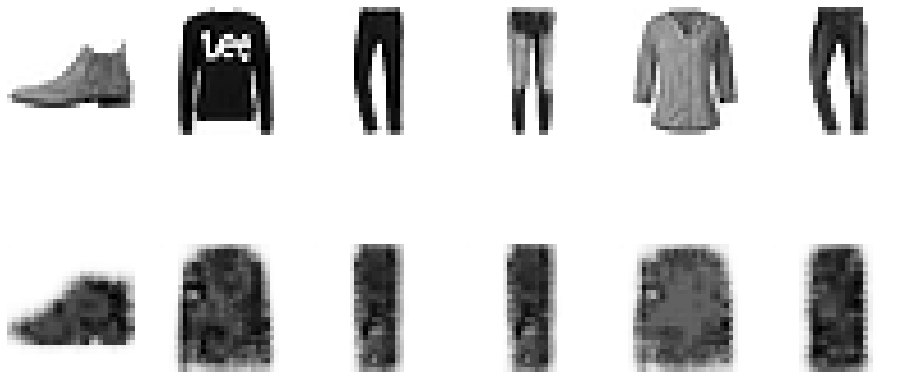

In [62]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 8))

for j in range(6):
    axs[0, j].imshow(example_x[j], cmap='binary')
    axs[1, j].imshow(example_reconstruction[j], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')